## Machine learning with CNN to measure lithium from spectra.

Here you can find the CNN model and the script for some of the plots used in the paper Nepal et al. 2022 : 

[arxiv.org/abs/2009.12872](https://arxiv.org/abs/2208.08874)

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:99% !important; }</style>"))

### IMPORT NECESSARY LIBRARIES

In [2]:
from datetime import datetime
from time import strftime

import pickle
import os
from copy import copy,deepcopy

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

from astropy.io import fits

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
#from sklearn.manifold import TSNE

In [3]:
import tensorflow as tf
from tensorflow import keras

# following are called for the ease of use. one could make do with just above calls.
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input, concatenate, LeakyReLU, Convolution1D, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping

print(np.__version__, tf.__version__, keras.__version__)

1.19.5 2.5.0 2.5.0


### LOAD THE DATA

In [4]:
# assigning and model version and the data version to keep track.

v                        = "v1"
data_version             = "GIRAFFE_HR15N"

filename_spectra        = 'training_data/spectra_'+ data_version +'_training.fits'
filename_labels         = 'training_data/labels_'+ data_version +'_training.csv'

In [5]:
#Load the Training Labels i.e. Teff, log(g), [Fe/H] and A(Li).
labels = pd.read_csv(filename_labels)

print(labels.shape)
label_names = labels.columns
labels.head(3)

(7031, 5)


,ges_spec_names,TEFF,LOGG,FEH,LI1
0,gir_05231610+0130158_H665.0.fit,4092.46,4.73,-0.20,0.24
1,gir_05233008+0147016_H665.0.fit,4234.17,4.75,0.00,0.31
2,gir_05240763+0123484_H665.0.fit,4560.25,4.69,0.08,0.04


In [6]:
# Load the training spectra. We also apply a condition to mask the H-alpha region.
hdu = fits.open(filename_spectra)
training_spec = hdu[0].data.T
spec_2320 = training_spec[2320,:]
del hdu #hdu.close()
print("The shape of the training spectra array before masking:  ",training_spec.shape)

# the wavelength values.
wl_range = np.arange(6450.0,6810.0,0.05)[10:7191]
#masking condition for H-alpha region
w_cond = (wl_range>6554.81)&(wl_range<6570.81)

# we now apply the mask.
training_spec = training_spec[:,np.logical_not(w_cond)]
print("The shape of the training spectra array after masking:  ",training_spec.shape)

The shape of the training spectra array before masking:   (7031, 7181)


The shape of the training spectra array after masking:   (7031, 6861)


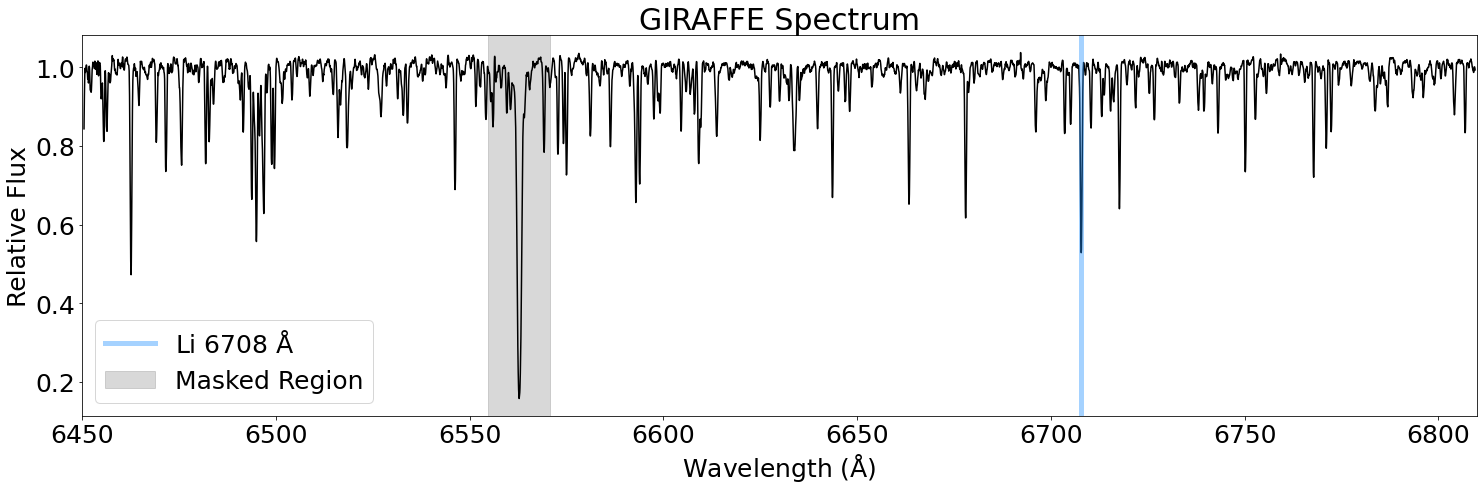

In [7]:
# This spectra has Teff, log(g), [Fe/H] and A(Li) of (4897,2.55,-0.11,2.63)

plt.rcParams.update({'font.size': 25})

wl_gir = np.arange(6450.0,6810.0,0.05)[10:7191]

fig = plt.figure(figsize=(25, 7))
gs = gridspec.GridSpec(nrows=1, ncols=1, height_ratios=[1.0], width_ratios=[1.0], wspace=0.0, hspace=0.0)
ax1 = plt.subplot(gs[0,0])
ax1.plot(wl_gir, spec_2320, c='k')
ax1.axvspan(6554.81, 6570.81, alpha=0.3, color='grey', label='Masked Region')
ax1.axvline(6707.8, lw=5, alpha=.4, color='dodgerblue', label='Li 6708 $\mathrm{\AA}$')#, ls=':'
ax1.set_xticks(np.arange(6450,6825,50))
ax1.set_xlim(6450,6810)
ax1.set_title("GIRAFFE Spectrum")
ax1.legend(loc='lower left')
ax1.set_xlabel("Wavelength ($\mathrm{\AA}$)")
ax1.set_ylabel("Relative Flux")
#plt.savefig("plots/a_giraffe_spectrum(4897,2.55,-0.11,2.63).png", bbox_inches='tight', dpi=200)
plt.show()

### Pre-processing data

In [8]:
# These values will be used for splitting the training sample into train and test sets (75% and 25%)
# the random_state is fixed for reproducibility.
validation_percent_split = 25
random_state = 101

In [9]:
X = training_spec.reshape(training_spec.shape[0], training_spec.shape[1], 1)
X = X.astype('float32')

#splitting training and test sample using sklearn train_test_split.
X_train, X_test, y_train, y_test, y_train_IDs, y_test_IDs = train_test_split(X, labels, labels[label_names[:1]].values, test_size = validation_percent_split/100.0, random_state=random_state)

#data_limits for training labels,
scaler_y = preprocessing.MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train[['TEFF', 'LOGG', 'FEH','LI1']].values.astype('float32'))
y_test_scaled = scaler_y.transform(y_test[['TEFF', 'LOGG', 'FEH','LI1']].values.astype('float32'))

print(X_train.shape)
print(X_test.shape)

print(y_train_scaled.shape)
print(y_test_scaled.shape)

print(y_train_IDs.shape)
print(y_test_IDs.shape)

(5273, 6861, 1)
(1758, 6861, 1)
(5273, 4)
(1758, 4)
(5273, 1)
(1758, 1)


<Figure size 432x288 with 0 Axes>

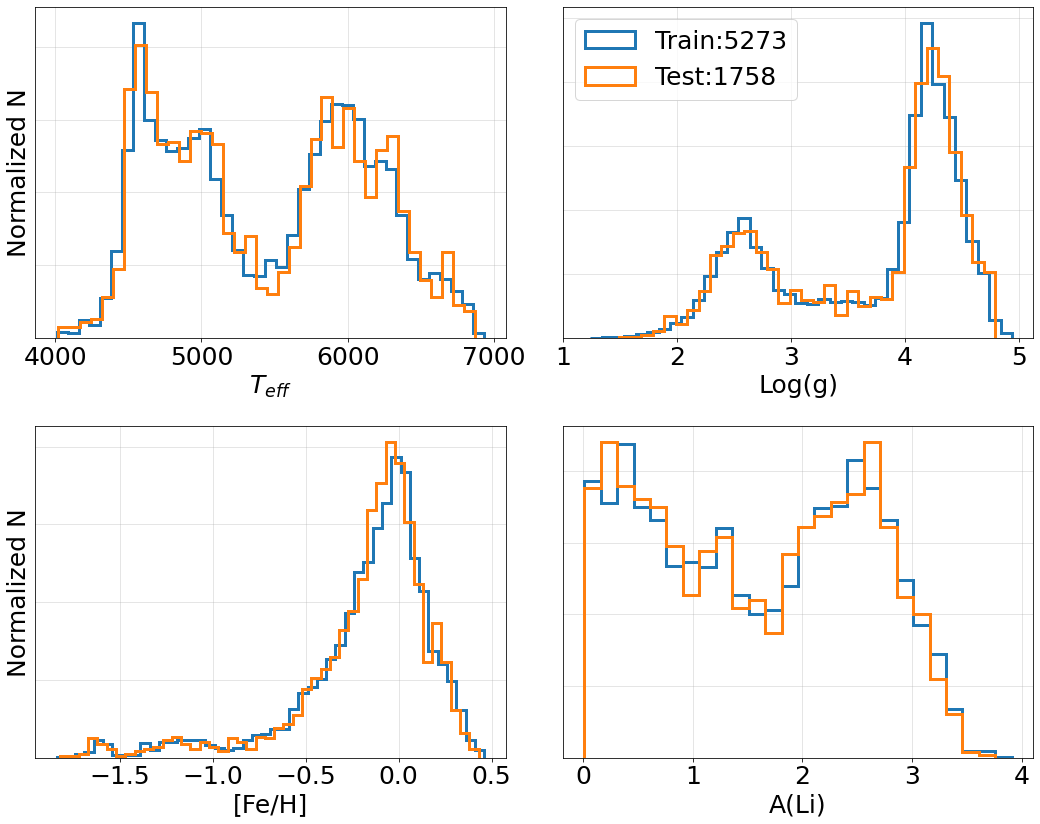

In [10]:
plt.rcParams.update({'font.size': 25})
plt.subplots_adjust(hspace=0.15, wspace=0.20)
fig = plt.figure(figsize=(15,12))

xticks = [[4000,5000,6000,7000], [1,2,3,4,5], [-1.5,-1,-0.5,0.0,0.5], [0,1,2,3,4] ]
bins = [75,0.1,0.05,0.15]
names = ['TEFF', 'LOGG', 'FEH', 'LI1']
names_t = ['$T_{eff}$', 'Log(g)', '[Fe/H]', 'A(Li)']
for ii,n in enumerate(names):
    ax = fig.add_subplot(2,2,ii+1)
    plt.tick_params(left = False, labelleft = False)
    plt.hist(y_train[n], bins=np.arange(min(y_train[n]), max(y_train[n]),bins[ii]), histtype='step', density=1, label="Train:" + np.str(len(y_train)), lw=3.0)
    plt.hist(y_test[n], bins=np.arange(min(y_test[n]), max(y_test[n]),bins[ii]), histtype='step', density=1, label="Test:" + np.str(len(y_test)), lw=3.0)
    ax.set_xlabel(names_t[ii])
    ax.grid(alpha=0.4)
    ax.set_xticks(xticks[ii])
    if ii == 0 or ii==2:
        ax.set_ylabel("Normalized N")
    if ii ==1:
        ax.legend(loc='upper left', fontsize=25)
plt.tight_layout()
#plt.savefig("plots/train_test_labels_histogram"+data_version+"_"+ v +".png", dpi=100, bbox_inches='tight')
plt.show()

### ARCHITECTURE OF THE NEURAL NETWORK

In [11]:
# We now construct our cnn model as a function.
def architecture(iptdim):

    ipt       = Input(shape=(iptdim, 1)) #layer with dimension corresponding to the number of pixels

    x = Convolution1D(8, kernel_size=10, kernel_regularizer=keras.regularizers.l2(0.005), padding='valid', name = 'convol_1')(ipt)
    x = LeakyReLU()(x)
    x = MaxPooling1D(pool_size=2, padding='valid')(x)

    x = Convolution1D(6, kernel_size=15, kernel_regularizer=keras.regularizers.l2(0.005), padding='valid', name = 'convol_2')(x)
    x = LeakyReLU()(x)
    x = MaxPooling1D(pool_size=2, padding='valid')(x)

    x = Convolution1D(4, kernel_size=10, kernel_regularizer=keras.regularizers.l2(0.005), padding='valid', name = 'convol_3')(x)
    x = LeakyReLU()(x)
    x = Dropout(0.20)(x)

    x = Flatten()(x)
    x = Dense(64, name = 'dense_1_1')(x)
    x = LeakyReLU()(x)

    x = Dropout(0.20)(x)
    x = Dense(128, name = 'dense_1_2')(x)
    x = LeakyReLU()(x)

    x = Dropout(0.20)(x)
    x = Dense(32, name = 'dense_1_3')(x)
    x = LeakyReLU()(x)

    cnnout = Dense(y_train.shape[1], activation='linear')(x)
    cnn = keras.Model(ipt, cnnout)

    return cnn

In [12]:
cnn = architecture(len(X_train[0]))
cnn.summary()
#keras.utils.plot_model(cnn, show_shapes=True, show_layer_names=False)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 6861, 1)]         0         
_________________________________________________________________
convol_1 (Conv1D)            (None, 6852, 8)           88        
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 6852, 8)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 3426, 8)           0         
_________________________________________________________________
convol_2 (Conv1D)            (None, 3412, 6)           726       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 3412, 6)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1706, 6)           0     

### INITIAL CONDITIONS

In [13]:
patience_n               = 25
batch_size               = 64
n_epoch_max              = 500
n_run                    = 30
learning_rate            = 0.0001
optimizer = keras.optimizers.Adam(learning_rate)

### TRAIN OUR MODEL

In [14]:
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Current Time =",current_time)

Current Time = 14:28:01


In [15]:
early_stop = EarlyStopping(monitor='val_loss', min_delta=learning_rate, patience=patience_n, verbose=1, mode='auto', restore_best_weights=True)

histories = []

iptdim = len(X_train[0])     # length of the spectra

# START THE N ITERATIONS.
for index_run in range(n_run):

    cnn = architecture(iptdim)
    cnn.compile(loss='mse', optimizer=optimizer, metrics=['mse'])   #create a cnn with initialized weights

    history = cnn.fit([X_train], y_train_scaled, batch_size=batch_size, epochs=n_epoch_max, validation_data=([X_test], y_test_scaled), verbose=0, callbacks=[early_stop])

    histories.append(history)

    #SAVE THE CNN MODEL
    cnn.save('cnn_models/'+data_version+"_"+ v +'_model_%03d' % index_run)

    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    print("Current Time =",current_time)
    print(index_run)

# SAVE THE DATA AND THE LIMITS
np.savez('cnn_output/data_model_' +data_version+"_"+ v + '.npz', X_train_tmp=X_train, y_train_scaled_tmp=y_train_scaled, X_test_tmp=X_test, y_test_scaled_tmp=y_test_scaled, label_names_tmp=label_names, limits_labels_tmp=scaler_y)

# SAVE THE HISTORIES
np.savez('cnn_output/histories_' +data_version+"_"+ v + '.npz', history= pd.DataFrame.from_dict(h.history for h in histories))#, allow_pickle=True)

### Select the best performing networks (80%) and plot the loss functions

In [16]:
#load the saved histories
saved_h = np.load('data_models/histories_' + v +'_'+ flag_out +"_" + flag_phot+ '.npz', allow_pickle=True)
best_val_loss = [min(saved_h['history'][i,2]) for i in range(saved_h['history'].shape[0])]
percentile = np.percentile(best_val_loss, 80.0)
index_good_training = np.array(np.where(best_val_loss < percentile)[0])
best_epoch = np.asarray([np.where(np.asarray(saved_h['history'][i,1]) == best_val_loss[i]) for i in range(saved_h['history'].shape[0])]).ravel()
last_val_loss = np.array([saved_h['history'][i,2][-1] for i in range(saved_h['history'].shape[0])])
last_val_loss1 = np.array([saved_h['history'][i,3][-1] for i in range(saved_h['history'].shape[0])])
last_epoch = np.array([len(saved_h['history'][i,2]) for i in range(saved_h['history'].shape[0])])

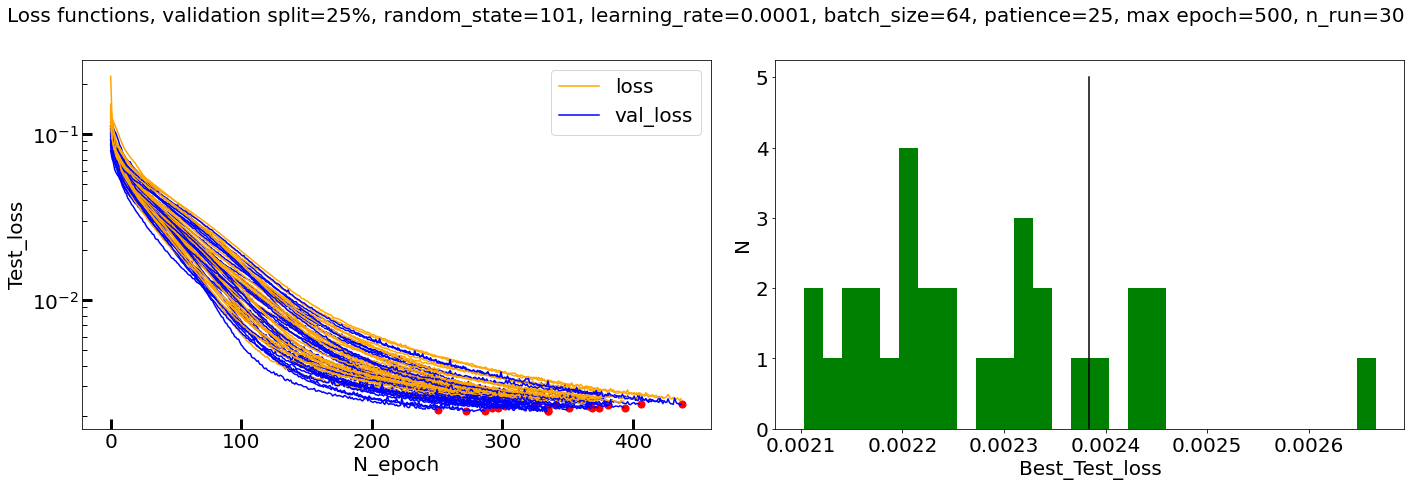

In [17]:
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(20,7))
plt.subplot(121)
for i in range(saved_h['history'].shape[0]):
    plt.plot(saved_h['history'][i,0], c='orange')
    plt.plot(saved_h['history'][i,2], c='b')
    plt.yscale('log')
    plt.xlabel("N_epoch")
    plt.ylabel("Test_loss")
    plt.legend(['loss','val_loss'])
plt.scatter(last_epoch[index_good_training], last_val_loss[index_good_training],marker='o', s=50, color='red')
plt.tick_params(which='major', length=10, width=3, direction='in', color='k')
plt.tick_params(which='minor', length=5, width=1, direction='in', color='k')

plt.subplot(122)
plt.hist(best_val_loss, bins = 30, histtype = 'stepfilled', facecolor = 'green')
plt.plot([percentile, percentile], [0.0, +5.0], c = 'black')
plt.xlabel("Best_Test_loss")
plt.ylabel("N")
plt.suptitle("Loss functions, validation split="+str(validation_percent_split)+"%, random_state="+ str(random_state)+", learning_rate="+np.str(learning_rate)+", batch_size="+np.str(batch_size)+", patience="+str(patience_n)+", max epoch="+str(n_epoch_max)+", n_run="+str(n_run), fontsize=20)
plt.tight_layout()
#plt.savefig("../plots/test_loss_acc_"+data_version+"_"+ v +".png", bbox_inches='tight')
plt.show()


### PREDICT USING THE BEST N MODELS AND GET THE RESULTS

In [18]:
#Add together the n_runs
res_train_all = np.zeros((len(index_good_training),len(y_train),    y_train.shape[1]))
res_test_all  = np.zeros((len(index_good_training),len(y_test),     y_train.shape[1]))

data = np.load('data_models/data_model_' +data_version+"_"+ v + '.npz', allow_pickle=True)

#create an empty list to add gradients
arr = []
#Set this to calculate_gradients=True if you want to calculate the gradients.
calculate_gradients = False

for idx, index_run  in enumerate(index_good_training):

    cnn = load_model('cnn_models/' + data_version + "_"+ v+ '_model_%03d' % index_run)
    if(use_param==False):
        res_train = cnn.predict([data['X_train_tmp']])
        res_test  = cnn.predict([data['X_test_tmp']])
        res_obs   = cnn.predict([X_obs])

    res_train_all[idx,:,:] = scaler_y.inverse_transform(res_train[:,:5])
    res_test_all[idx,:,:]  = scaler_y.inverse_transform(res_test[:,:5])

    if calculate_gradients:
        #This is for the calculations of gradients
        eg = []
        spec = tf.Variable(X_train, dtype=np.float32)
        for i in range(y_train.shape[1]):
            with tf.GradientTape() as tape:
                tape.watch(spec)
                prediction = cnn([spec], training=False)
                loss = tf.keras.losses.mse(y_train[:,i], prediction[:,i:i+1])
                grad = tape.gradient(prediction[:,i:i+1], spec)
                eg.append(grad)
        arr1 = np.array(eg)
        arr.append(arr1)
        del arr1, eg, spec, loss, grad, prediction

    print("Prediction complete using model: "index_run)

#This will save the gradients.
if calculate_gradients:
    arr = np.array(arr)
    #save the gradients
    np.savez('data_models/gradients_train_set_'+data_version+"_"+ v + '.npz', gradients= arr)

### SAVE THE DATA

In [19]:
# mean of the cnn predicted labels from best models as the final result and
# standard deviation as the uncertainty.

final_res_train = np.mean(res_train_all, axis = 0)
final_res_test  = np.mean(res_test_all,  axis = 0)

final_std_error_train = np.std(res_train_all, axis = 0)
final_std_error_test  = np.std(res_test_all,  axis = 0)

In [21]:
label_nam = np.array(label_names[1:])
error_nam = np.array(["e" + suit for suit in label_names[1:]])
label    = np.concatenate((label_nam, error_nam))

#Save results from res_train
df_res_train = pd.DataFrame(np.hstack((final_res_train, final_std_error_train)), columns=label)
df_res_train["spectra"]= y_train_IDs
df_res_train.to_csv("output/res_train_"+data_version+"_"+ v +".csv",index=False)

#Save results from res_test
df_res_test  = pd.DataFrame(np.hstack((final_res_test, final_std_error_test)), columns=label)
df_res_test["spectra"]= y_test_IDs
df_res_test.to_csv("output/res_test_"+data_version+"_"+ v +".csv",index=False)

### SOME COMPARISION PLOTS

In [22]:
#load the train set results.

df_res_train = pd.read_csv("output/res_train_"+data_version+"_"+ v +".csv")
df_res_test = pd.read_csv("output/res_test_"+data_version+"_"+ v +".csv")

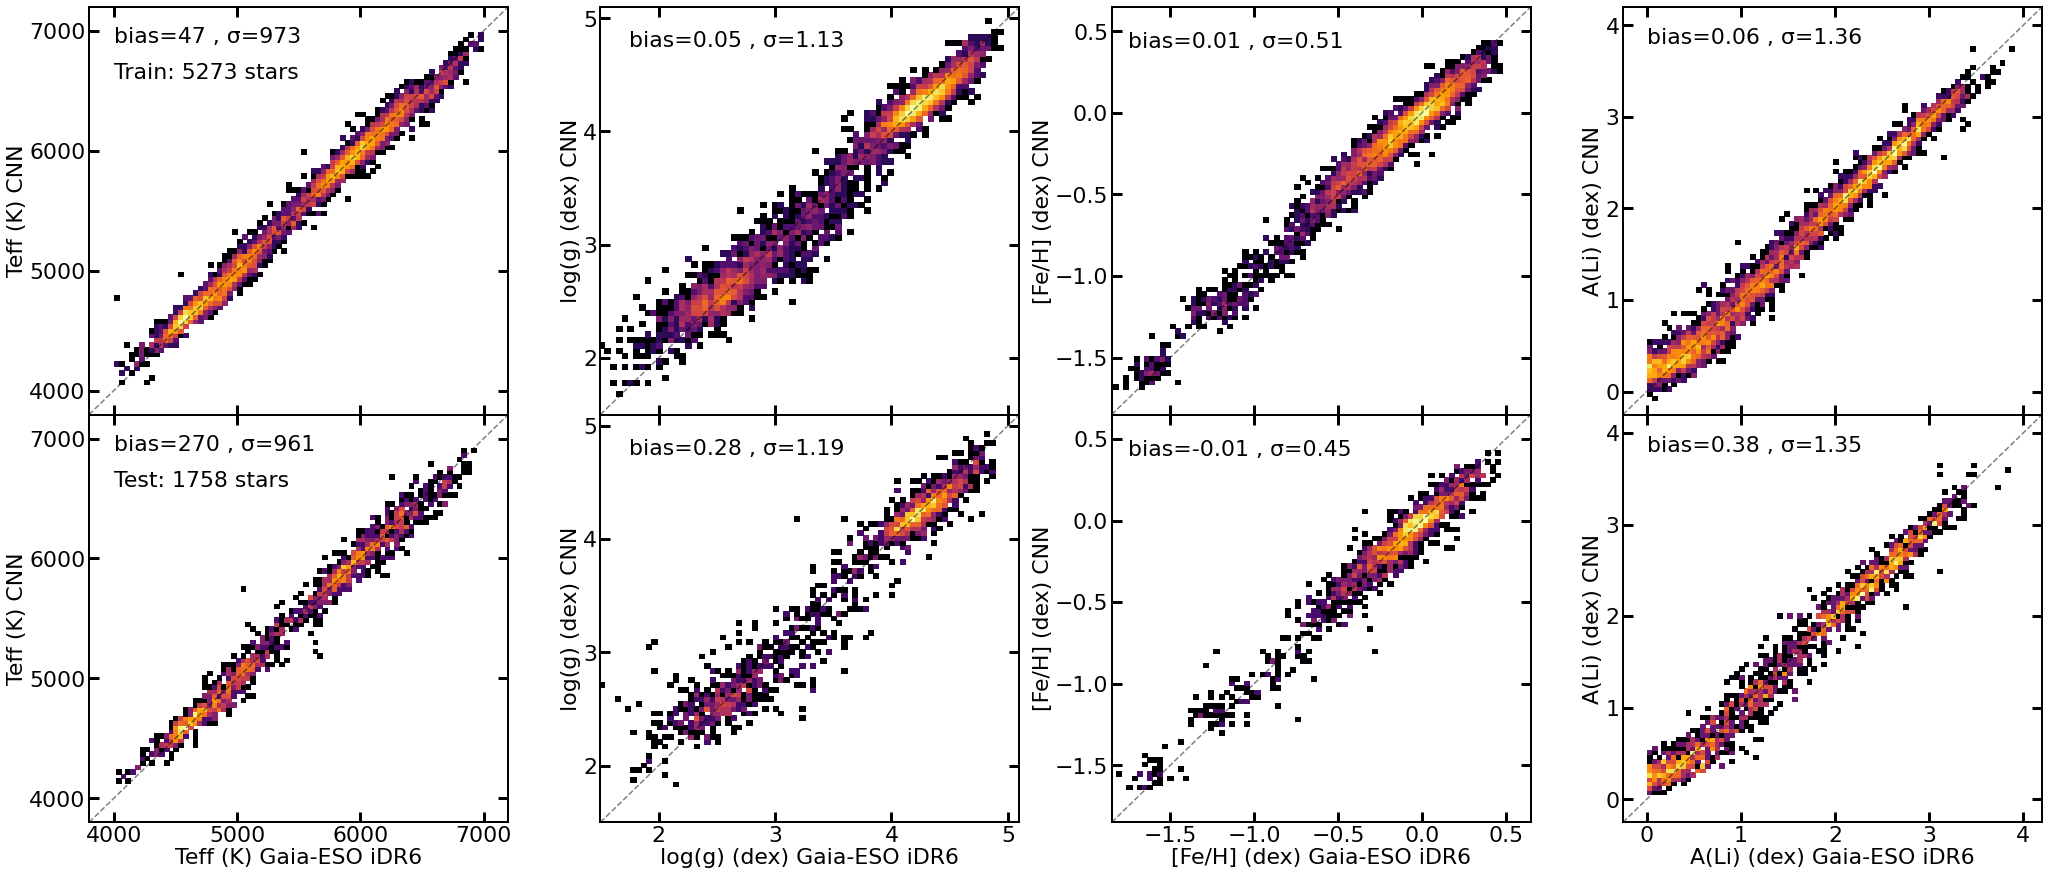

In [23]:
xmine = [3800.0, +1.5, -1.85, -0.25]
xmaxe = [7200.0, +5.1, +0.65, +4.2]
ymine = [-500.0, -0.5, -0.5, -1.5]
ymaxe = [+500.0, +0.5, +0.5, +1.5]
x_disp = [4000.0, 1.75, -1.75, 0.0]
y_disp = [6900.0, 4.75, +0.4, +3.8]
corr   = [200.0, 0.25, 0.2, 0.25]
xticks = [[4000,5000,6000,7000], [2,3,4,5], [-1.5,-1.0,-0.5,0.0,+0.5], [0,1,2,3,4]]

plt.rcParams.update({'font.size': 22, 'axes.linewidth':2.0})

xlab = ["Teff (K)", "log(g) (dex)", "[Fe/H] (dex)", "A(Li) (dex)"]
elements = ['TEFF', 'LOGG', 'FEH', 'LI1']

fig = plt.figure(figsize=(35, 15))
gs = gridspec.GridSpec(2, 4, height_ratios=[1.0,1.0], width_ratios=[1.0,1.0,1,1])
arond=2

for idx,elem in enumerate(elements):
    arond=2
    bias_train=round(np.mean(df_res_train[elem]-y_train[elem]),arond)
    std_train=round(np.std(df_res_train[elem]-y_train[elem]),arond)
    bias_test=round(np.mean(df_res_test[elem]-y_test[elem]),arond)
    std_test=round(np.std(df_res_test[elem]-y_test[elem]),arond)
    ax0 = plt.subplot(gs[idx])
    ax0.hist2d(y_train[elem], df_res_train[elem], bins=75, cmap = 'inferno', norm = LogNorm())
    ax0.set_xlim(xmine[idx], xmaxe[idx])
    ax0.set_ylim(xmine[idx], xmaxe[idx])
    ax0.set_yticks(xticks[idx])
    ax0.set_ylabel(xlab[idx] + " CNN",labelpad=2)
    ax0.plot([xmine[idx], xmaxe[idx]], [xmine[idx], xmaxe[idx]],linestyle='--',color='black', alpha=0.5)
    if elem=='TEFF':
        ax0.text(x_disp[idx], y_disp[idx], "bias="+'%.0f'%bias_train + " , \u03C3=" + '%.0f'%std_train,color='k')
    else:
        ax0.text(x_disp[idx], y_disp[idx], "bias="+'%.2f'%bias_train + " , \u03C3=" + '%.2f'%std_train,color='k')
    ax0.tick_params(labelbottom = False, bottom = True, top=True, right=True, length=10, width=3, direction='in', color='k')
    if idx==0:
        ax0.text(x_disp[idx], y_disp[idx]-300, "Train: " + str(len(df_res_train)) + ' stars',color='k')

    ax0 = plt.subplot(gs[idx+4])
    ax0.hist2d(y_test[elem],  df_res_test[elem], bins=75, cmap = 'inferno', norm = LogNorm())
    ax0.set_xlim(xmine[idx], xmaxe[idx])
    ax0.set_ylim(xmine[idx], xmaxe[idx])
    ax0.set_yticks(xticks[idx])
    ax0.set_ylabel(xlab[idx] + " CNN",labelpad=2)
    ax0.plot([xmine[idx], xmaxe[idx]], [xmine[idx], xmaxe[idx]],linestyle='--',color='black', alpha=0.5)
    if elem=='TEFF':
        ax0.text(x_disp[idx], y_disp[idx], "bias="+'%.0f'%bias_test + " , \u03C3=" + '%.0f'%std_test,color='k')
    else:
        ax0.text(x_disp[idx], y_disp[idx], "bias="+'%.2f'%bias_test + " , \u03C3=" + '%.2f'%std_test,color='k')
    ax0.set_xlabel(xlab[idx] + " Gaia-ESO iDR6",labelpad=2)
    ax0.tick_params(length=10, width=3, top=True, right=True, direction='in', color='k')
    if idx==0:
        ax0.text(x_disp[idx], y_disp[idx]-300, "Test: " + str(len(df_res_test)) + ' stars',color='k')

plt.subplots_adjust(hspace=.00, wspace=0.22)
#plt.savefig("plots/training_1_to_1_CNN_vs_iDR6_"+ data_version+"_"+ v +".png", bbox_inches='tight', dpi=100)
plt.show()

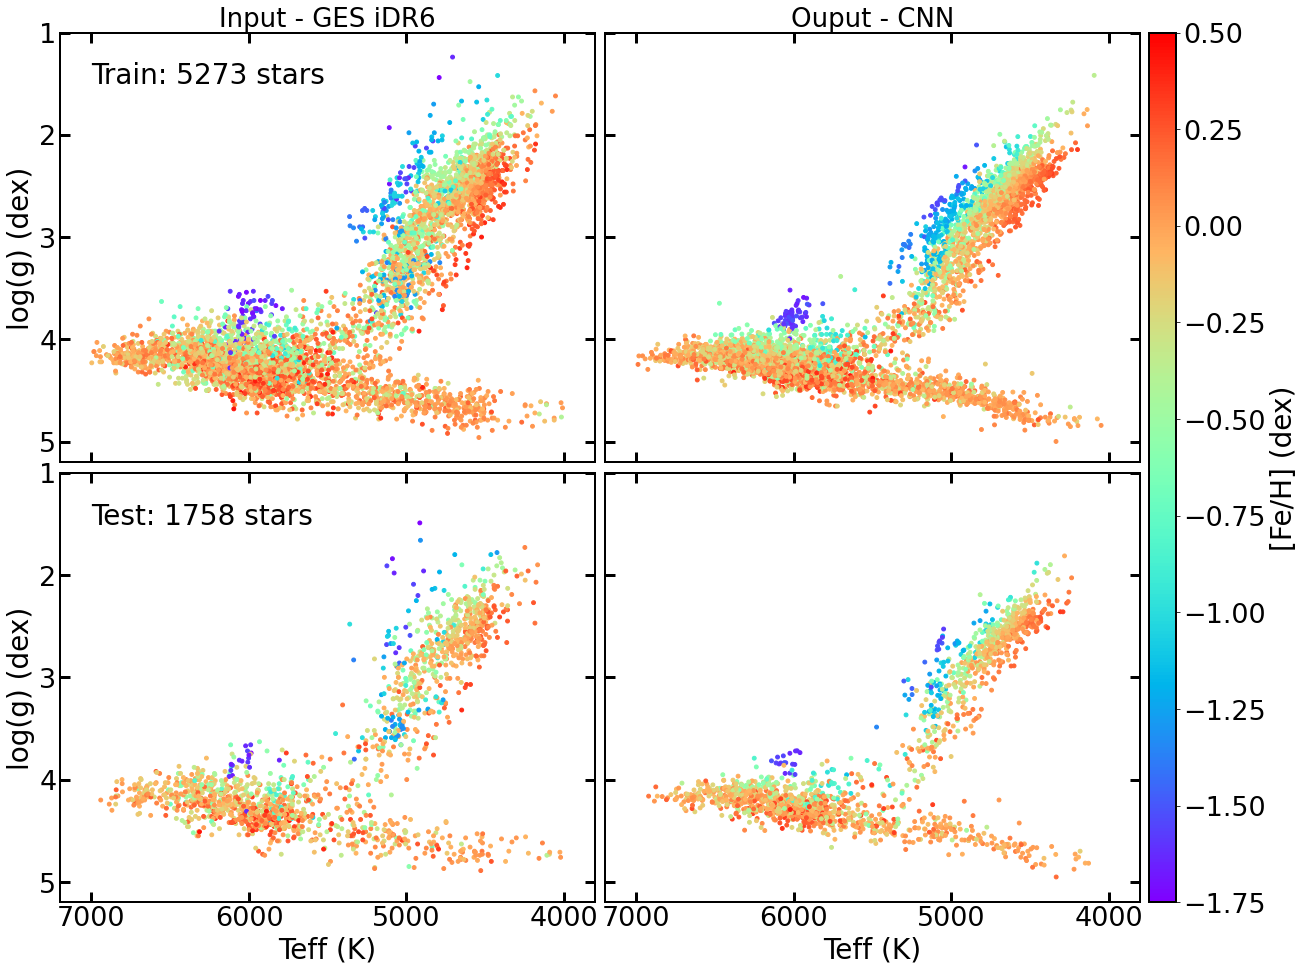

In [24]:
fig=plt.figure(figsize=(20,16))

plt.rcParams.update({'font.size': 27})
plt.rcParams['axes.linewidth'] = 2.0
gs = gridspec.GridSpec(2, 3, height_ratios=[1,1], width_ratios=[1.0,1.0,0.05], wspace=0.025, hspace=0.025)

ax=fig.add_subplot(gs[0,0])
df=pd.DataFrame({'TEFF' : y_train.TEFF, 'log(g)' : y_train.LOGG, '[Fe/H]' : y_train.FEH})
df.plot.scatter('TEFF','log(g)',c='[Fe/H]',s=15.0, alpha=1.5,ax=ax,colormap='rainbow', vmin=-1.75,vmax=+0.5, rasterized=True, colorbar=False)
ax.set_xlim([7200.0, 3800.0])
ax.set_xticks([7000, 6000, 5000,4000])
ax.set_ylim([5.2, 1.0])
ax.set_yticks([5,4,3,2,1])
ax.set_xlabel('Teff (K)', fontsize=28)
ax.set_ylabel('log(g) (dex)', fontsize=28)
ax.set_title("Input - GES iDR6", fontsize=26)
ax.text(7000.0, +1.5, "Train: "+np.str(len(y_train.TEFF)) + " stars", color='black', fontsize=28)
ax.tick_params(left = True, right = True, top=True , bottom = True, labelleft = True, labelbottom = False, which='major', length=10, width=3, direction='in', color='k')
ax.xaxis.label.set_visible(False)

ax=fig.add_subplot(gs[0,1])
df=pd.DataFrame({'TEFF' : df_res_train.TEFF, 'log(g)' : df_res_train.LOGG, '[Fe/H]' : df_res_train.FEH})
df.plot.scatter('TEFF','log(g)',c='[Fe/H]',s=15.0, alpha=1.5,ax=ax,colormap='rainbow', vmin=-1.75,vmax=+0.5, rasterized=True, colorbar=False)
ax.set_xlim([7200.0, 3800.0])
ax.set_xticks([7000, 6000, 5000,4000])
ax.set_ylim([5.2, 1.0])
ax.set_yticks([5,4,3,2,1])
ax.set_xlabel('Teff (K)', fontsize=28)
ax.set_title("Ouput - CNN", fontsize=26)
ax.tick_params(left = True, right = True, top=True , labelleft = False, labelbottom = False, bottom = True, which='major', length=10, width=3, direction='in', color='k')
ax.yaxis.label.set_visible(False)
ax.xaxis.label.set_visible(False)


ax=fig.add_subplot(gs[1,0])
df=pd.DataFrame({'TEFF' : y_test.TEFF, 'log(g)' : y_test.LOGG, '[Fe/H]' : y_test.FEH})
df.plot.scatter('TEFF','log(g)',c='[Fe/H]',s=15.0, alpha=1.5,ax=ax,colormap='rainbow', vmin=-1.75,vmax=+0.5, rasterized=True, colorbar=False)
ax.set_xlim([7200.0, 3800.0])
ax.set_xticks([7000, 6000, 5000,4000])
ax.set_ylim([5.2, 1.0])
ax.set_yticks([5,4,3,2,1])
ax.set_xlabel('Teff (K)', fontsize=28)
ax.set_ylabel('log(g) (dex)', fontsize=28)
ax.text(7000.0, +1.5, "Test: "+np.str(len(y_test.TEFF)) + " stars", color='black', fontsize=28)
ax.tick_params(left = True, right = True, top=True , labelleft = True, which='major', length=10, width=3, direction='in', color='k')

ax=fig.add_subplot(gs[1,1])
df=pd.DataFrame({'TEFF' : df_res_test.TEFF, 'log(g)' : df_res_test.LOGG, '[Fe/H]' : df_res_test.FEH})
df.plot.scatter('TEFF','log(g)',c='[Fe/H]',s=15.0, alpha=1.5,ax=ax,colormap='rainbow', vmin=-1.75,vmax=+0.5, rasterized=True, colorbar=False)
ax.set_xlim([7200.0, 3800.0])
ax.set_xticks([7000, 6000, 5000,4000])
ax.set_ylim([5.2, 1.0])
ax.set_yticks([5,4,3,2,1])
ax.set_xlabel('Teff (K)', fontsize=28)
ax.set_ylabel('log(g) (dex)', fontsize=28)
ax.yaxis.label.set_visible(False)
ax.tick_params(left = True, right = True, top=True , labelleft = False, which='major', length=10, width=3, direction='in', color='k')

cax=fig.add_subplot(gs[0:2,2:3])
cmap = matplotlib.cm.rainbow
norm = matplotlib.colors.Normalize(vmin=-1.75,vmax=+0.5)
cb1 = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, orientation='vertical')
cb1.set_label('[Fe/H] (dex)', fontsize=28)

#plt.savefig("plots/kiel_diagram_input_output_"+ data_version+"_"+ v +".png", dpi = 100, bbox_inches='tight')
plt.show()

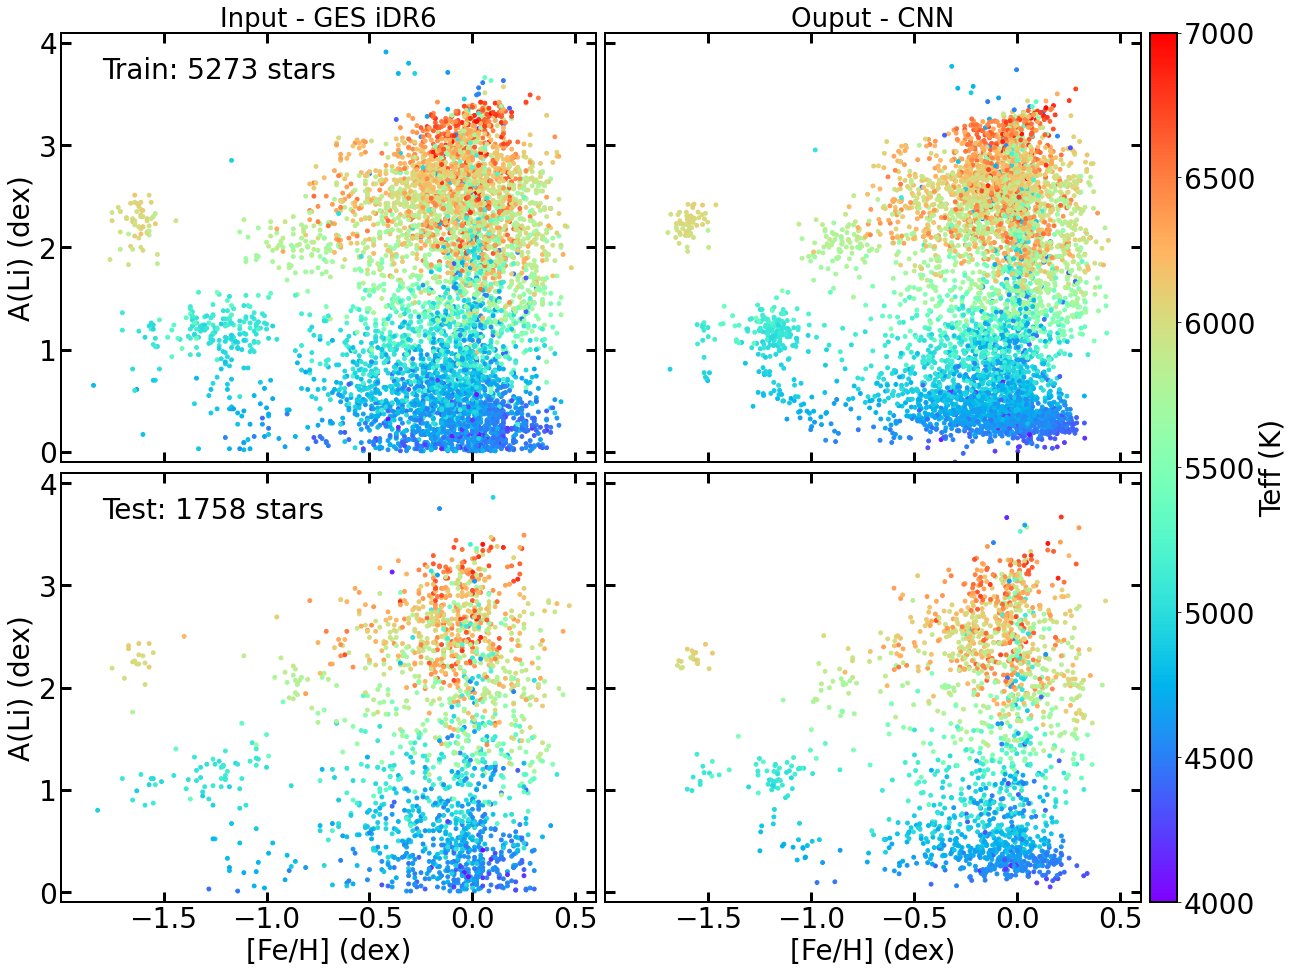

In [25]:
fig=plt.figure(figsize=(20,16))

plt.rcParams.update({'font.size': 28})
plt.rcParams['axes.linewidth'] = 2.0
gs = gridspec.GridSpec(2, 3, height_ratios=[1,1], width_ratios=[1.0,1.0,0.05], wspace=0.025, hspace=0.025)

#For train set
ax=fig.add_subplot(gs[0,0])
ax.tick_params(labelbottom = False, bottom = False)
axs = y_train.plot.scatter('FEH','LI1',s=15, alpha=1.5,ax=ax,c='TEFF', cmap='rainbow', vmin=4000,vmax=7000,rasterized=True, colorbar = False)
ax.set_xlim([-2., 0.6])
ax.set_ylim([-0.1, 4.1])
ax.set_yticks([0,1,2,3,4])
ax.set_xticks([-1.5, -1.0, -0.5, 0, 0.5])
ax.set_ylabel('A(Li) (dex)')
ax.text(-1.8, +3.65, "Train: "+np.str(len(y_train.TEFF)) + " stars", color='black', fontsize=28)
ax.tick_params(left = True, right = True, top=True , bottom = True, labelleft = True, labelbottom = False, which='major', length=10, width=3, direction='in', color='k')
ax.xaxis.label.set_visible(False)
ax.set_title("Input - GES iDR6", fontsize=26)

ax=fig.add_subplot(gs[0,1])
ax = df_res_train.plot.scatter('FEH','LI1',s=15, alpha=1.5,ax=ax,c='TEFF', cmap='rainbow', vmin=4000,vmax=7000,rasterized=True, colorbar = False)
ax.set_xlim([-2., 0.6])
ax.set_ylim([-0.1, 4.1])
ax.set_yticks([0,1,2,3,4])
ax.set_xticks([-1.5, -1.0, -0.5, 0, 0.5])
ax.tick_params(left = False, right = False , labelleft = False,  labelbottom = False, bottom = False)
ax.yaxis.label.set_visible(False)
ax.xaxis.label.set_visible(False)
ax.set_title("Ouput - CNN", fontsize=26)
ax.tick_params(left = True, right = True, top=True , bottom = True, labelleft = False, labelbottom = False, which='major', length=10, width=3, direction='in', color='k')

#For test set
ax=fig.add_subplot(gs[1,0])
y_test.plot.scatter('FEH','LI1',s=15, alpha=1.5,ax=ax,c='TEFF', cmap='rainbow', vmin=4000,vmax=7000,rasterized=True, colorbar = False)
ax.set_xlim([-2., 0.6])
ax.set_ylim([-0.1, 4.1])
ax.set_yticks([0,1,2,3,4])
ax.set_xticks([-1.5, -1.0, -0.5, 0, 0.5])
ax.set_xlabel('[Fe/H] (dex)')
ax.set_ylabel('A(Li) (dex)')
ax.text(-1.8, +3.65, "Test: "+np.str(len(y_test.TEFF)) + " stars", color='black', fontsize=28)
ax.tick_params(left = True, right = True, top=True , bottom = True, labelleft = True, labelbottom = True, which='major', length=10, width=3, direction='in', color='k')

ax=fig.add_subplot(gs[1,1])
axs = df_res_test.plot.scatter('FEH','LI1',s=15, alpha=1.5,ax=ax,c='TEFF', cmap='rainbow', vmin=4000,vmax=7000,rasterized=True, colorbar = False)
ax.set_xlim([-2., 0.6])
ax.set_ylim([-0.1, 4.1])
ax.set_yticks([0,1,2,3,4])
ax.set_xticks([-1.5, -1.0, -0.5, 0, 0.5])
ax.set_xlabel('[Fe/H] (dex)')
ax.set_ylabel('A(Li) (dex)')
ax.yaxis.label.set_visible(False)
ax.tick_params(left = True, right = True, top=True , labelleft = False, which='major', length=10, width=3, direction='in', color='k')

cax=fig.add_subplot(gs[0:2,2:3])
cmap = matplotlib.cm.rainbow
norm = matplotlib.colors.Normalize(vmin=4000, vmax=7000)
cb1 = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, orientation='vertical')
cb1.set_label('Teff (K)')

#plt.savefig("../plots/feh_vs_li_input_output_"+ data_version+"_"+ v +"_2.png", dpi = 100, bbox_inches='tight')
plt.show()

###  PLOTTING THE GRADIENTS 

In [26]:
#load the train set results.

df_res_train = pd.read_csv("output/res_train_"+ data_version+"_"+ v + ".csv")
print(df_res_train.shape)

#load the saved gradients for train set

gradients = np.load('data_models/gradients_train_set_'+ data_version+"_"+ v +'.npz', allow_pickle=True)
gradients = gradients['gradients']
print(gradients.shape)

(5273, 9)


(4, 5273, 6861)


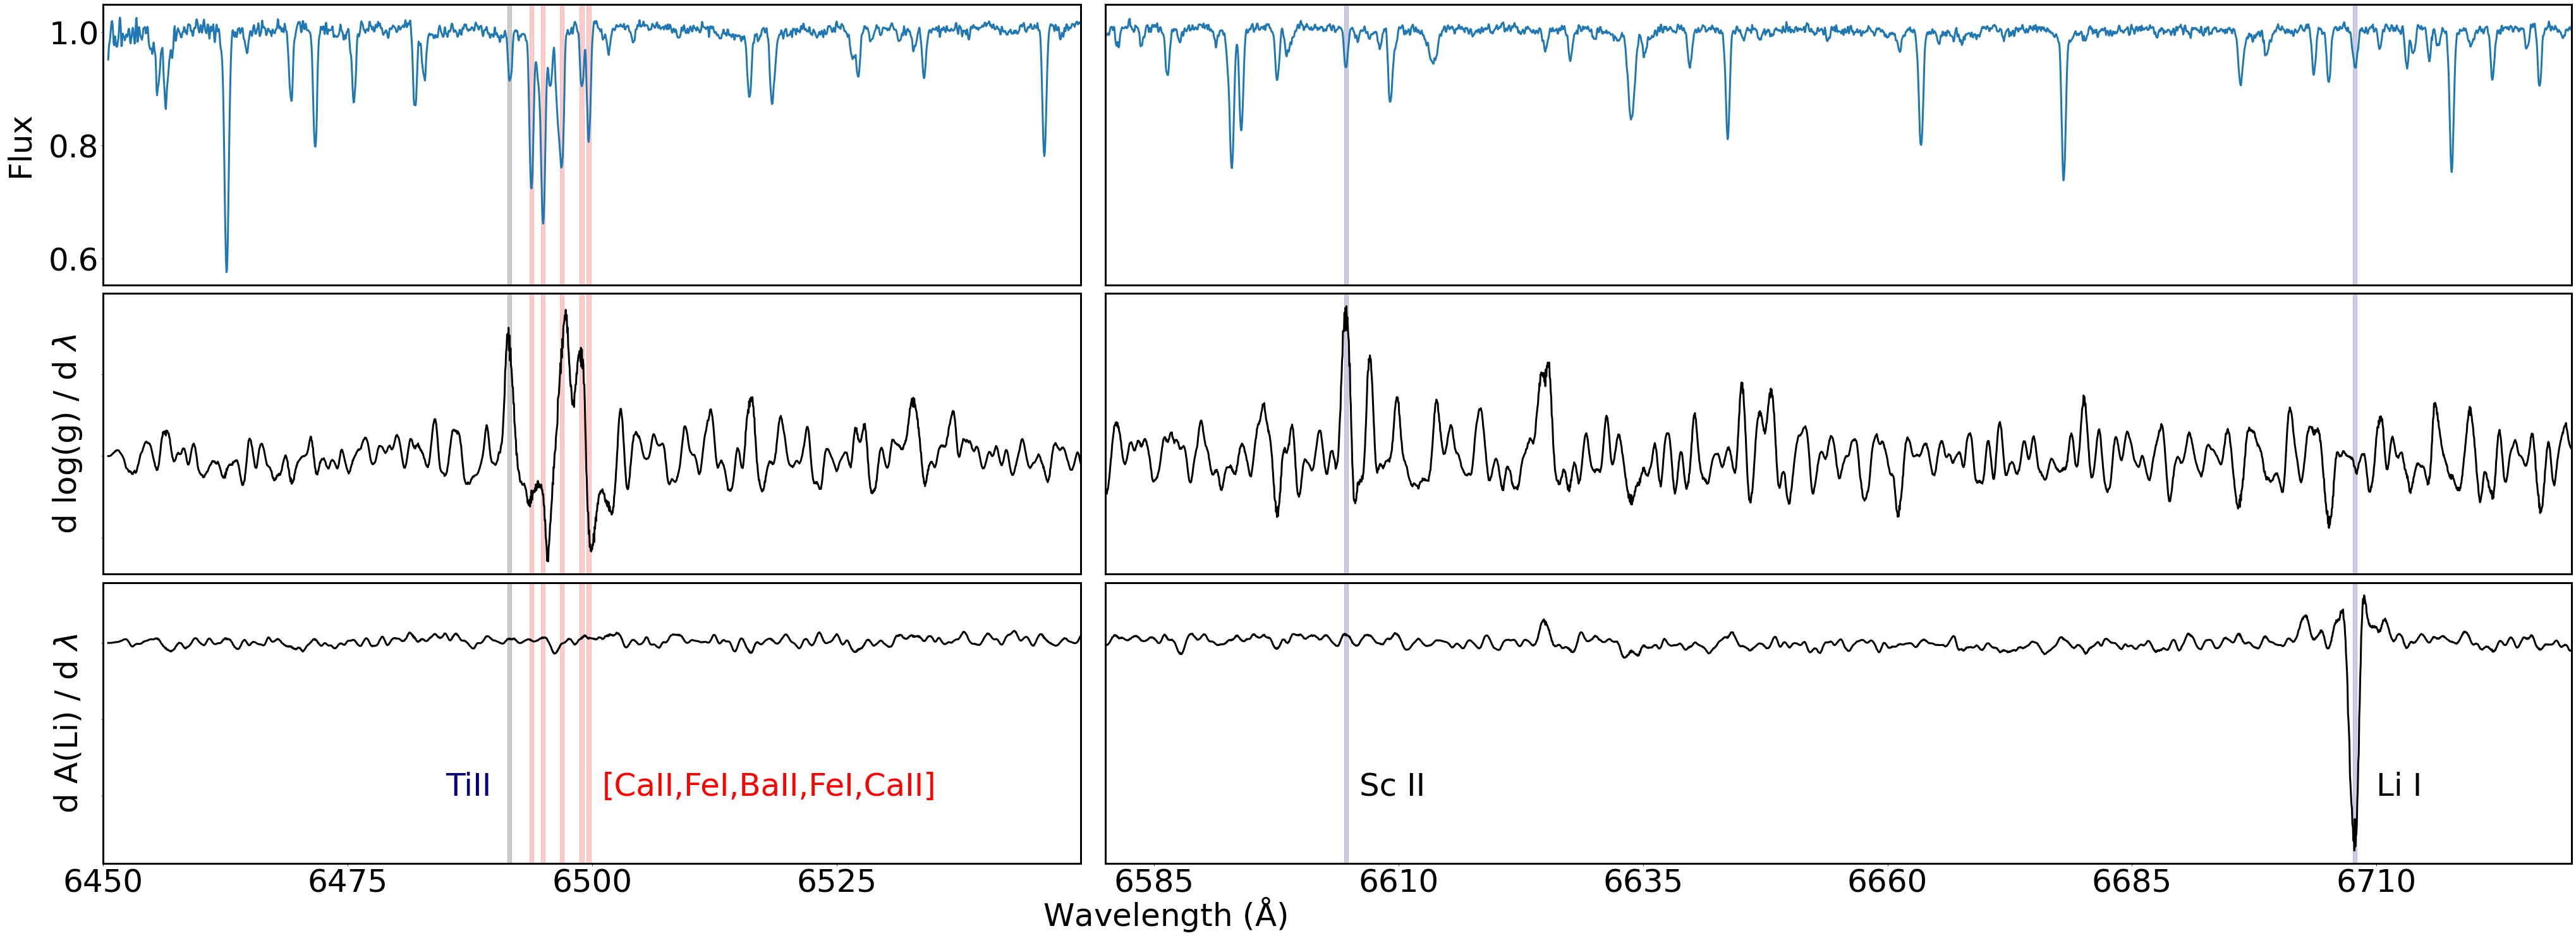

In [27]:
#Simple plot showing CNN gradients as a fucntion of the input labels for solar-twins.
#Some important spectral features discussed in the paper are also highlighted.

#selecting solar-twins from the training set.
selection = (df_res_train.TEFF > 5752.0) & (df_res_train.TEFF < 5802.0) & (df_res_train.LOGG < 4.54) & (df_res_train.LOGG > 4.34) & (df_res_train.FEH < +0.05) & (df_res_train.FEH > -0.05)

ylabels = ['d log(g) / d $\lambda$', 'd A(Li) / d $\lambda$']

wl_range = np.arange(6450.0,6810.0,0.05)[10:7191]
w_cond = (wl_range>6554.81)&(wl_range<6570.81)

spec_m = np.mean(X_train.reshape(X_train.shape[0], X_train.shape[1])[selection,:],axis=0)

plt.rcParams.update({'font.size': 50})
plt.rcParams['axes.linewidth'] = 3.0
fig = plt.figure(figsize=(70,25), facecolor='white')
gs = gridspec.GridSpec(nrows=3, ncols=2, width_ratios=[0.4,0.6], wspace=0.02, hspace=0.03)

ax = fig.add_subplot(gs[0,0])
ax.plot(wl_range[np.logical_not(w_cond)], spec_m, color='C0', alpha=1.0, lw=3.0)
for kk in [6493.78, 6494.98, 6496.897, 6498.94, 6499.65]:
    ax.axvspan(kk-0.2, kk+0.2, color="red", alpha=0.2)
ax.axvspan(6491.56 - 0.2, 6491.56 + 0.2, alpha=0.2, color='k')
ax.set_xticks(np.arange(6450,6810,25))
ax.set_xlim(6450,6550)
ax.set_ylabel("Flux")
ax.axes.xaxis.set_visible(False)
ax.yaxis.set_label_coords(-.07, .5)

ax = fig.add_subplot(gs[0,1])
plt.plot(wl_range[np.logical_not(w_cond)], spec_m, color='C0', alpha=1.0, lw=3.0)
ax.axvspan(6707.8-0.2, 6707.8+0.2, alpha=0.2, color='navy', label='Li I')
ax.axvspan(6604.6010-0.2, 6604.6010+0.2, alpha=0.2, color='navy', label='Sc II')
ax.set_xticks(np.arange(6450,6810,25))
ax.set_xlim(6580,6730)
ax.set_ylabel("Flux")
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

for num,i in enumerate([1,3]):
    ax = fig.add_subplot(gs[num+1,0])
    gradien = np.mean(gradients[:,selection,:], axis=1)[i,:]
    #plot the gradient
    plt.plot(wl_range[np.logical_not(w_cond)], gradien, c='k', lw=3.0)
    #plot the lines
    for kk in [6493.78, 6494.98, 6496.897, 6498.94, 6499.65]:
        ax.axvspan(kk-0.2, kk+0.2, color="red", alpha=0.2)
    ax.axvspan(6491.56 - 0.2, 6491.56 + 0.2, alpha=0.2, color='k')
    ax.set_xticks(np.arange(6450,6550,25))
    ax.set_xlim(6450,6550)
    ax.set_ylabel(ylabels[num])
    ax.axes.xaxis.set_visible(False)
    ax.tick_params(labelleft = False)
    ax.yaxis.set_label_coords(-.02, .5)
    if i==3:
        ax.axes.xaxis.set_visible(True)
        ax.text(6501.0, -0.20, "[CaII,FeI,BaII,FeI,CaII]", color="red")
        ax.text(6485.0, -0.20, "TiII", color="navy")

for num,i in enumerate([1,3]):
    ax = fig.add_subplot(gs[num+1,1])
    gradien = np.mean(gradients[:,selection,:], axis=1)[i,:]
    plt.plot(wl_range[np.logical_not(w_cond)], gradien, c='k', lw=3.0)
    ax.axvspan(6707.8-0.2, 6707.8+0.2, alpha=0.2, color='navy', label='Li I')
    ax.axvspan(6604.6010-0.2, 6604.6010+0.2, alpha=0.2, color='navy', label='Sc II')
    ax.set_xticks(np.arange(6585,6750,25))
    ax.set_xlim(6580,6730)
    ax.set_ylabel(ylabels[num])
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    if i==3:
        ax.axes.xaxis.set_visible(True)
        ax.text(6710,-0.2,'Li I')
        ax.text(6606,-0.2,'Sc II')

fig.text(0.42,0.07, "Wavelength ($\mathrm{\AA}$)", fontsize=50, c='k')
#plt.savefig("plots/gradients_logg_li.png", bbox_inches='tight', dpi = 100)
plt.show()